# Settling Time After a Slew

This notebook evaluates the RMS of displacement values against long-term position and rotation measurements taken by the IMS at M1M3. It returns the settling time determined by when the values of the IMS measurement with respect to its long term behavior (determined by the parameter postPadding in seconds after the slew stop) becomes compatible with the standard deviation, using a chi2 test.

Note that in this version of the notebook, you will have to introduce the dayObs and slew of interest to be analyzed.

[LVV-T11258]: https://jira.lsstcorp.org/browse/LVV-11258

### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from scipy import stats

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst.summit.utils.blockUtils import BlockParser

import warnings

warnings.filterwarnings("ignore")

In [3]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [4]:
req_delta_t = 2.5  ## seconds after slew
req_rms_position = (
    2e-3  ## mm, tolerance from repeatability requirement for IMS positional
)
req_rms_rotation = (
    3e-5  ## degrees, tolerance from repeatability requirement for IMS rotational
)

#### Observation day

In [5]:
## Insert here the dayObs of interest
dayObs = 20231121

#### Get slew stops

In [6]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type == TMAState.SLEWING]
tracks = [e for e in events if e.type == TMAState.TRACKING]
print(f"Found {len(slews)} slews and {len(tracks)} tracks")

Found 183 slews and 109 tracks


#### Define specific slew, and maximum time after event for calculations and plots 

In [7]:
## Insert here the slew of interest, to be analyzed
# define specific slew
i_slew = 75  # 35  # 75
# define time padding after end of slew
postPadding = 15  # in seconds

In [10]:
## Define column names
all_columns = [
    "xPosition",
    "yPosition",
    "zPosition",
    "xRotation",
    "yRotation",
    "zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

### Define functions

#### measure settling time

This is the function that will return the number of seconds it takes for the queried IMS value to settle, using a chi2 test of bias vs long term value.

In [78]:
def computeSettleTime(
    df_ims,  # input data frame
    referenceTime="2023-06-01T06:00:0Z",  # time for slew stop (T0)
    lo_delta_t=5,  # in seconds
    hi_delta_t=30,  # in seconds
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    req_delta_t=3,  # time for settling, in seconds
    chi2prob=0.999,  # confidence level for IMS variable wrt to long term value and variance to agree
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.0001
    else:
        print("Unidentified column")
        return -1

    # T0 and T1 defines the window for requirement to be met
    T0 = pd.to_datetime(referenceTime)  # this is slew stop
    T1 = T0 + pd.to_timedelta(
        req_delta_t, unit="s"
    )  # this is the end of maximum req. window
    delta_window = [
        pd.Timedelta(lo_delta_t, "seconds"),
        pd.Timedelta(hi_delta_t, "seconds"),
    ]
    # zoom around the T0 of interest
    TZoom = [T0 - delta_window[0], T0 + delta_window[1]]

    # targetVariablePlot takes the data frame for the complete plot range
    targetVariablePlot = df_ims[imsColumn][TZoom[0] : TZoom[1]]
    # targetVariableCheck takes the data from the slew stop, until the end of the plot
    targetVariableCheck = df_ims[imsColumn][T0 : TZoom[1]]
    # targetVariableWindow takes the data from the slew stop, until the end of requirement window
    targetVariableWindow = df_ims[imsColumn][T0:T1]
    idxT0 = df_ims.index[  # index in dataframe closest in time to slew stop
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = (
        df_ims.index[  # index in dataframe closest in time to end of requirement window
            df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
        ]
    )
    idxTend = df_ims.index[  # index in dataframe closest in time to end of plot
        df_ims.index.get_indexer(
            [pd.to_datetime(T0 + delta_window[1])], method="nearest"
        )
    ]
    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxTend]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1

    # it is important that the end of the plot (targetVariableReference[1])
    # does not hit another slew or movement, nor at any point in the middle of the window

    # correct IMS variable wrt end of plot
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]
    correctedVariableCheck = targetVariableCheck - targetVariableReference[1]
    correctedVariableCheck2 = np.square(correctedVariableCheck)

    # number of values where the chi2 will be computed
    rolling = 20  # 50 is approx. 1 s
    # chi2 right tail probability for N=rolling dof at chi2prob CL
    crit = stats.chi2.ppf(chi2prob, rolling)

    rms = correctedVariableCheck.rolling(rolling).std()
    var = correctedVariableCheck.rolling(rolling).var()
    mean = abs(correctedVariableCheck.rolling(rolling).mean())

    # compute the chi2 against the null hypothesis
    # the x_i are the measurements in a window (wrt to reference at end of plot)
    # the variance is for the same values
    # so chi2 = sum_N[(x_i - 0)**2/variance] where N = rolling
    sum2 = correctedVariableCheck2.rolling(rolling).sum()
    chi2 = sum2 / var
    # check the chi2 at each step using rollingCheck as the number of consecutive instances in which
    # chi2 has to be under the critical value
    # or rms be already 20% of requirement
    PFCheck = (chi2 < crit) | (rms < 0.2 * rmsReq) | (mean < 0.1 * rmsReq)
    rollingCheck = 100
    stabilityCheck = (
        PFCheck.rolling(rollingCheck).apply(lambda s: s.all()) > 0
    )  # true if rollingCheck consecutive true values of PFcheck
    if len(stabilityCheck[stabilityCheck == True]) == 0:
        # print(f"Not settled within {postPadding} s window")
        settleTime = False
    elif rms[stabilityCheck[stabilityCheck == True].index[0]] <= rmsReq:
        settleTime = stabilityCheck[stabilityCheck == True].index[0 + rollingCheck]  
    else:
        n = 1
        while (
            rms[stabilityCheck[stabilityCheck == True].index[n + rollingCheck]] > rmsReq
        ):
            settleTime = stabilityCheck[stabilityCheck == True].index[n + rollingCheck]
            n = n + 1
        # if settleTime < referenceTime:
        #    settleTime = referenceTime
    settleInterval = -1
    if settleTime:
        settleInterval = settleTime - referenceTime
        if settleInterval.total_seconds() < 0:
            print(f"Already settled at slew stop")
            settleInterval = 0
        else:
            settleInterval = settleInterval.total_seconds()

    title = imsColumn
    fig = plt.figure()
    label = "Corrected " + imsColumn + "(" + units + ") difference wrt end of plot"
    plt.plot(
        correctedVariablePlot,
        color="red",
        ls="dashed",
        lw="0.5",
        label=label,
    )
    plt.plot(rms, label=f"RMS of corrected value, using {rolling} rolling values")
    # plt.plot(
    #    mean,
    #    ls="dashed",
    #    label=f"Bias of corrected value, using {rolling} rolling values",
    # )
    if settleTime:
        plt.arrow(
            settleTime,
            1.1 * rmsReq,
            0.0,
            -0.5 * rmsReq,
            width=2e-6,
            head_length=0.5 * rmsReq,
        )
        plt.text(
            0.5,
            0.92,
            "Settle time =" + " {:.2f} ".format(settleInterval) + " s",
            transform=fig.transFigure,
        )
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label="Slew stop")
    plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label="IMS repeatability req.")
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
    plt.xlabel("Time [UTC]")
    plt.ylabel(f"{imsColumn} {units}")
    plt.ylim(-ylimMax, ylimMax)
    fig.autofmt_xdate()
    plt.legend(loc="upper right", fontsize="8")
    fig.tight_layout()

    if not settleTime:
        return -1

    return settleInterval

#### compare IMS vs mount data

This is an auxiliary function to plot information from the IMS with respect to the elevation and azimuth measurements from the mount.

In [9]:
def compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    referenceTime="2023-06-01 06:53:37.326",
    lo_delta_t=5,  # in seconds
    hi_delta_t=60,
):  # in seconds
    fig, axs = plt.subplots(5, 1, dpi=125, figsize=(6, 8))
    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(
        lo_delta_t, unit="s"
    )  ##correcting by hand for TAI, is this correct?
    t_end_plot = pd.to_datetime(referenceTime) + pd.to_timedelta(hi_delta_t, unit="s")

    ax = axs[0]
    actpos_ele = df_mtmount_ele["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_ele, color="red", lw="0.5")
    ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k")
    ax.set_ylabel("Elevation \nPosition\n[deg]")

    ax = axs[1]
    actpos_azi = df_mtmount_azi["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_azi, color="red", lw="0.5")
    ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k", label="Slew stop")
    ax.set_ylabel("Azimuth \nPosition\n[deg]")

    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(lo_delta_t, unit="s")
    t_end_plot = pd.to_datetime(referenceTime) + pd.to_timedelta(hi_delta_t, unit="s")

    plotstring = ["xPosition", "yPosition", "zPosition"]
    plotrange = np.arange(len(plotstring))
    for i in plotrange:
        ax = axs[i + 2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos, color="red", lw="0.5")
        ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k")
        ax.set_ylabel(plotstring[i] + " \n[mm]")
    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(referenceTime)
    fig.legend()
    fig.tight_layout()
    ### TBD: use a delta time wrt slew stop in x-label

### Load data

In [11]:
t0 = Time(slews[i_slew].begin, format="isot", scale="utc")
t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
t1 = Time(slews[i_slew].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
print("Slew stop at:", t1)

# Get IMS data
# Note that we need data beyond the associated to the slew stop,
# which just covers the slew itself, ie, while the telescope is moving (TBC)
df_ims = getEfdData(
    client, "lsst.sal.MTM1M3.imsData", event=slews[i_slew], postPadding=postPadding
)
df_ims = df_ims[all_columns]
# Convert meter to milimeter
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

Slew stop at: 2023-11-22 01:31:53.320000+00:00


In [67]:
# Get mount data
df_mtmount_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", event=slews[i_slew], postPadding=postPadding
)
df_mtmount_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", event=slews[i_slew], postPadding=postPadding
)

### Look at data

This step is not necessary, but useful to get a visual impression of how the IMS data vary with TMA movements.

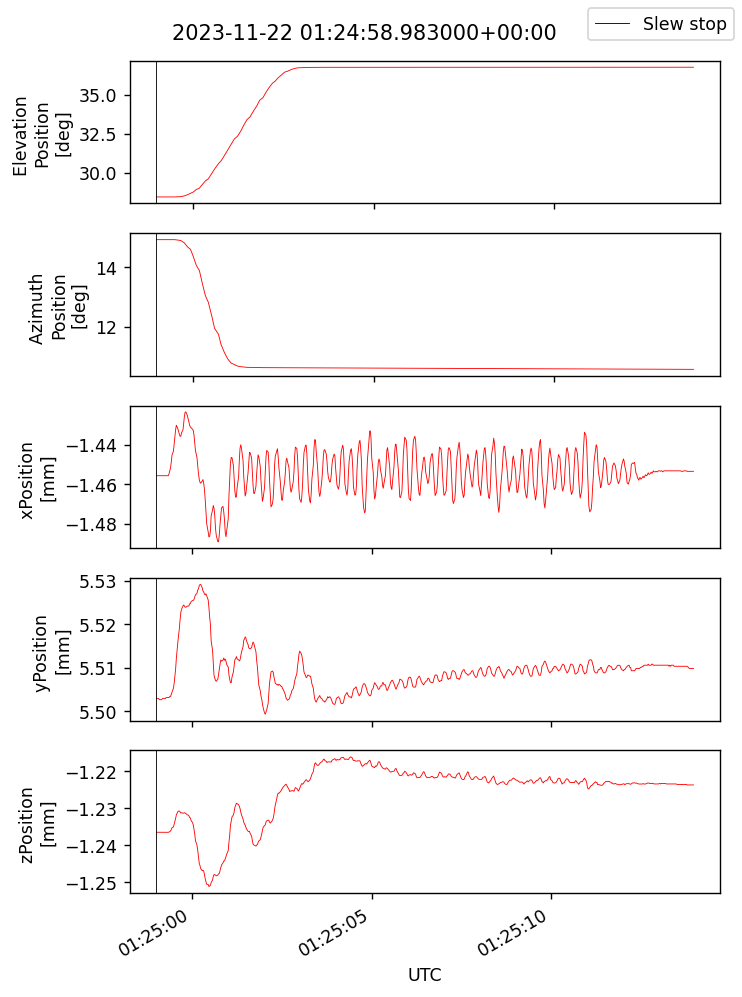

In [68]:
%matplotlib inline
compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    t1,
    10,
    pd.to_timedelta(postPadding, unit="s"),
)

### Run test

Currently the test involves executing the determineSettleTime function. The test will return the settle time determined by a chi square test under a certain probability (default is 0.999) that the IMS variable fluctuactions with respect to the value at postPadding seconds after slew stop is compatible with the RMS of the variable itself. Also, it is required that the RMS is below the IMS requirement for position or rotation.

Slew stop at: 2023-11-22 00:54:25.736000+00:00
xPosition settled in 5.30 s
yPosition settled in 5.30 s
zPosition settled in 5.30 s
xRotation settled in 5.53 s
yRotation settled in 5.30 s
zRotation settled in 5.30 s
Average settling time is 5.34 s


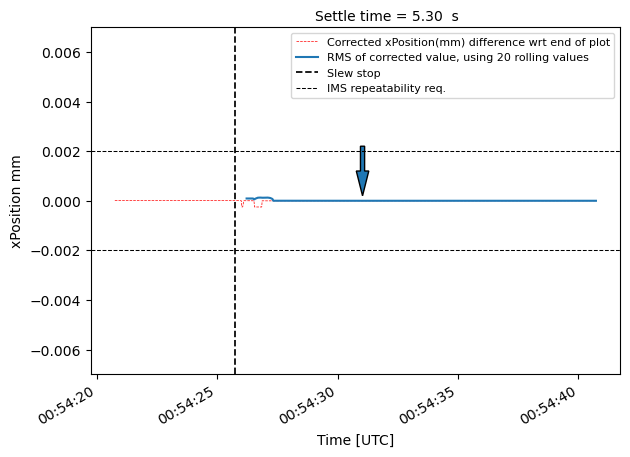

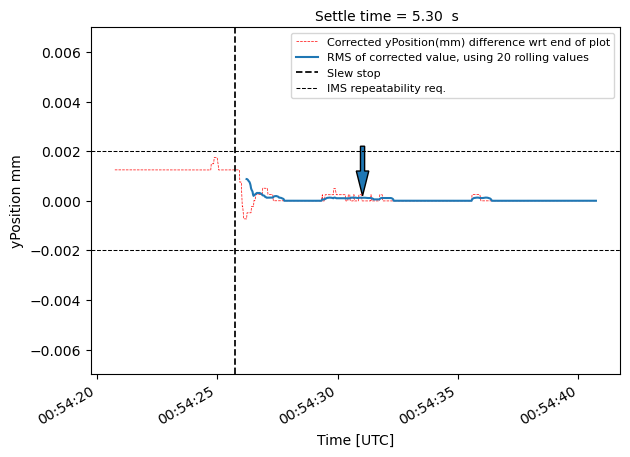

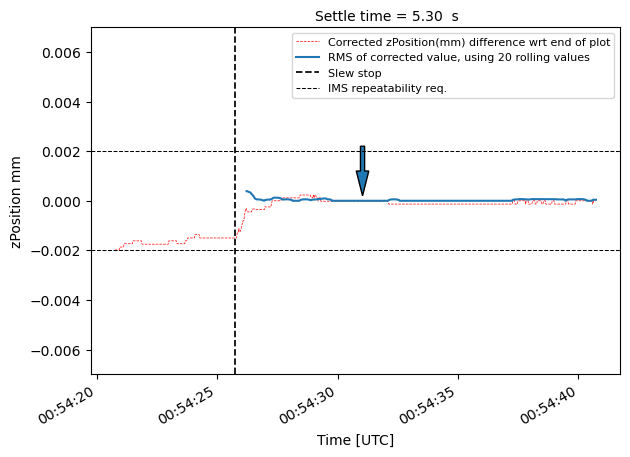

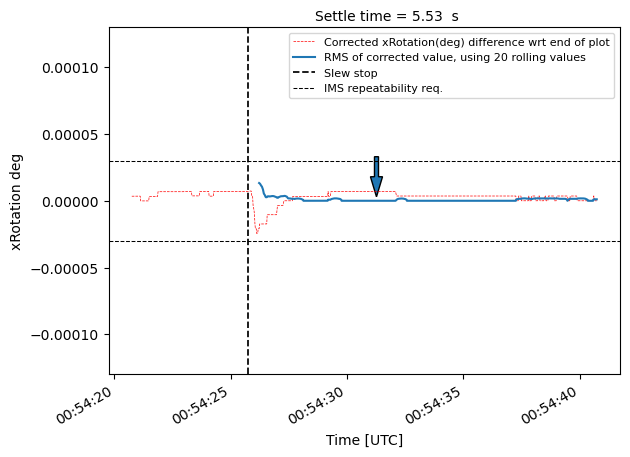

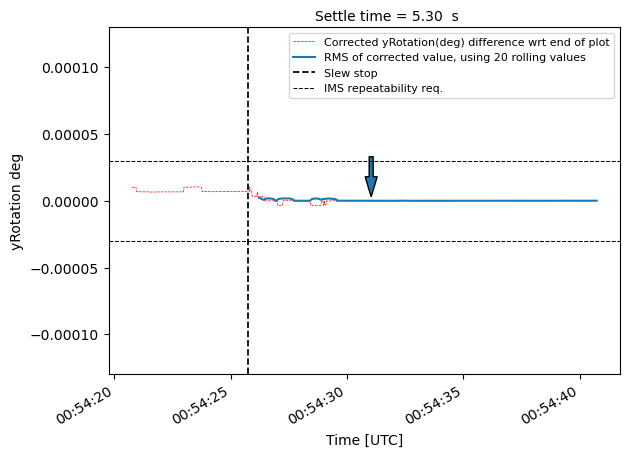

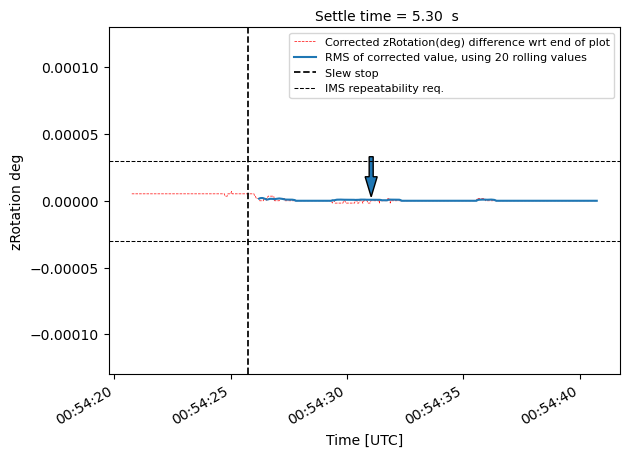

In [82]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option("display.max_rows", None)
settle_intervals = np.empty(6)
c = 0
i_slew = 65  # GOOD: 65 INTERESTING: 66, 67 STRANGE:
t1 = Time(slews[i_slew].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)
print("Slew stop at:", t1)
df_ims = getEfdData(
    client, "lsst.sal.MTM1M3.imsData", event=slews[i_slew], postPadding=postPadding
)
df_ims = df_ims[all_columns]
df_ims[pos_columns] = df_ims[pos_columns] * 1e3
for col in all_columns:
    if col in pos_columns:
        req = req_rms_position
    else:
        req = req_rms_rotation
    settle_interval = computeSettleTime(
        df_ims=df_ims,
        referenceTime=t1,
        lo_delta_t=5,
        hi_delta_t=postPadding,
        imsColumn=col,
        rmsReq=req,
        req_delta_t=req_delta_t,
        chi2prob=0.999,
    )
    if settle_interval >= 0:
        print(f"{col} settled in {settle_interval:.2f} s")
    else:
        print(f"{col} not settled in {postPadding} s")
    settle_intervals[c] = settle_interval
    c = c + 1
avg = np.mean(settle_intervals[settle_intervals >= 0])
print(f"Average settling time is {avg:.2f} s")

In [ ]:
computeSettleTime(
    df_ims=df_ims,
    referenceTime=t1,
    lo_delta_t=5,
    hi_delta_t=postPadding,
    imsColumn="zRotation",
    rmsReq=req_rms_rotation,
    req_delta_t=req_delta_t,
    chi2prob=0.999,
)

In [16]:
# now let's try to look for many slews (but w/o plots)
dayObs = 20231122
blockParser = BlockParser(dayObs)
print(f"Found blocks for {dayObs}: {blockParser.getBlockNums()}")
blockNums = blockParser.getBlockNums()

Found blocks for 20231122: [13, 61, 135, 137]


In [17]:
block137Events = []
events = eventMaker.getEvents(dayObs)
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 137
    blockNums = {b.blockNumber for b in blockInfos}
    if 137 in blockNums:
        block137Events.append(event)

print(f"Of the {len(events)} events, {len(block137Events)} relate to block 137.")

Of the 351 events, 268 relate to block 137.


In [23]:
number_soak_events = len(block137Events)
for i in range(number_soak_events):
    print(block137Events[i].seqNum)
    

53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
102
103
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
213
215
216
222
223
224
225
226
227
228
229
230
231
232
233
234
239
240
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
